# About the code
This code is going to be the main to collect and create analysis output to answer the question "Quantifying political stance of Japanese Diet members regards specific political topics through the use of LLMs and statistical methods." (Tentative) 

## Part 1: Procedure for measuring embeddings
1. Create embeddings for each opinion-based sentence in regards to different topics and store it in a retrievable manner.
2. Create one single "opinion-embedding" for each politician and store it in a retrievable manner.
3. Create a stance axis vector by either generating two reference points or picking two points "opinion-embeddings" from the data
4. Collapse all the other vectors onto this axis by projecting them onto the axis
5. Create a scalar measurement for how far each politician is from the two reference points
6. Use UMAP dim reduction to see the positions of the politicians as well as the generated/selected reference points

## Part 2: Creating groups of politicians based on where their embeddings lie on an axis 
This is to get an idea of the ideas mentioned by politicians in a axis group within each topic using BERTopic. 
1. Divide politicians into n groups based on where they lie on the axis.
2. Extract opinion sentences of each group made. 
3. Run each group through topic modelling techniques.

### Notes
- Data is stored under `data/data_repr` directory
- We will attempt the procedure with different models to seek the best output

In [1]:
import os
from sentence_transformers import models, SentenceTransformer
import h5py
import umap
import numpy as np
import torch
from datetime import datetime
from tqdm import tqdm
from params.paths import ROOT_DIR
import japanize_matplotlib 
import matplotlib.pyplot as plt
import logging
from file_handling.file_read_writer import read_json, write_json, create_dir, write_file, read_hdf5_file, read_txt_file
import random as rnd

VERBOSE = True

#Logger
log_dir = os.path.join(ROOT_DIR, 'logs')
logging.basicConfig(filename=os.path.join(log_dir, 'quantify_politician_stance.log'), filemode='w', format='%(asctime)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
#Data Dir
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_REPR_SPEECHES_DIR = os.path.join(DATA_DIR, 'data_repr_lower')
#Resources
RESOURCE_DIR = os.path.join(ROOT_DIR, 'resource')
#Results
RESULTS_DIR = os.path.join(ROOT_DIR, 'results')
TODAYS_RESULTS = os.path.join(RESULTS_DIR, datetime.now().strftime('%Y%m%d'))
create_dir(RESULTS_DIR)
create_dir(TODAYS_RESULTS)
#Plots
TODAYS_PLOTS = os.path.join(TODAYS_RESULTS, 'plots')
create_dir(TODAYS_PLOTS)
#Configs
EXPERIMENT_CONFIG_PATH = os.path.join(RESOURCE_DIR, 'experiment_config.json')
EXPERIMENT_CONFIG = read_json(EXPERIMENT_CONFIG_PATH)
#Other data
PARTIES = [party for party in os.listdir(DATA_REPR_SPEECHES_DIR) if not '.' in party]
PARTY_TO_COLOR = {
	'自民': 'black',
	'国民': 'blue',
	'立憲': 'orange',
	'公明': 'lightblue',
	'共産': 'red',
	'維新': 'gold',
	'れ新': 'green',
	'無': 'purple',
	'有志': 'grey'
}
TOPICJP_TO_TOPICEN = {
	'防衛': 'Defence',
	'原発': 'Nuclear Power',
	'経済': 'Economy',
	'気候変動': 'Climate Change',
	'少子化': 'Declining Birthrate',
}
PARTYJP_TO_PARTYEN = {
	'自民': 'LDP',
	'国民': 'NDP',
	'立憲': 'CDP',
	'公明': 'Komeito',
	'共産': 'JCP',
	'維新': 'JRP',
	'れ新': 'Reiwa',
	'無': 'None',
	'有志': 'Independents'

}
IGNORE_PARTIES = ['無', '有志', 'れ新']
PARTY_TO_IDX = {party: idx for idx, party in enumerate(PARTIES)}
IDX_TO_PARTY = {idx: party for idx, party in enumerate(PARTIES)}
if len(PARTIES) != len(PARTY_TO_COLOR):
	raise ValueError('PARTIES and PARTY_TO_COLOR must have the same length.')
MODEL_NAME = "cl-tohoku/bert-base-japanese-v3"
print('-----------------------------------')
print('DATA_DIR: ', DATA_DIR)
print('DATA_REPR_SPEECHES_DIR: ', DATA_REPR_SPEECHES_DIR)
print('PARTIES: ', PARTIES)
print('-----------------------------------')

/root/projects/kokkai_analysis/data_prepping/kokkai_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----------------------------------
DATA_DIR:  /root/projects/kokkai_analysis/data_prepping/params/../data
DATA_REPR_SPEECHES_DIR:  /root/projects/kokkai_analysis/data_prepping/params/../data/data_repr_lower
PARTIES:  ['自民', '国民', '公明', '立憲', 'れ新', '維新', '無', '共産', '有志']
-----------------------------------


In [2]:
# adapted from: https://osima.jp/posts/sentence-bert/
def fix_seed(seed=42):
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.backends.cudnn.deterministic = True

fix_seed()

sentence_transformer = models.Transformer(MODEL_NAME)

pooling = models.Pooling(
    sentence_transformer.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=False,
    pooling_mode_cls_token=True,
    pooling_mode_max_tokens=False)

st = SentenceTransformer(modules=[sentence_transformer, pooling])
gen_for_embedding = st.encode('これとかあれとか', convert_to_tensor=True, show_progress_bar=True)
print('shape', gen_for_embedding.shape)

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

shape torch.Size([768])


## 1. Creating the embeddings for each opinion-based sentence

In [ ]:
def embed_speeches(speeches):
	encoded_opinions = st.encode(speeches, convert_to_tensor=True, show_progress_bar=True)
	return encoded_opinions

def read_opinion_sentences_and_dates(file_path):
	logger.message(f'Reading {file_path}')
	target_dict = read_json(file_path)
	if not target_dict:
		return [], []
	opinion_sentences = []
	dates = []
	for speech in target_dict['speeches']:
		date = [speech['date'] for _ in range(len(speech['extracted_opinions']))]
		opinions = speech['extracted_opinions']
		opinion_sentences.extend(opinions)
		dates.extend(date)
	
	return opinion_sentences, dates

def iterate_topics_for_repr(repr_path, topics=[]):
	for topic in os.listdir(repr_path):
		if topic not in topics and topics:
			continue
		logger.message(f'Working on {topic}')
		topic_path = os.path.join(repr_path, topic)
		if os.path.exists(os.path.join(topic_path, 'embeddings.hdf5')):
			logger.message(f'Embeddings already exist for {topic} in {repr_path}')
			continue
		file_path = os.path.join(topic_path, 'opinions.json')
		topic_opinions, topic_dates = read_opinion_sentences_and_dates(file_path)
		if not topic_opinions:
			logger.message(f'No opinions found for {topic} in {repr_path}')
			continue
		embeddings = embed_speeches(topic_opinions)
		embeddings = [embedding.cpu() for embedding in embeddings]
		logger.message(f'Number of dates {len(topic_dates)}\nNumber of opinions {len(topic_opinions)} \nNumber of embeddings {len(embeddings)}')
		embeddings = torch.stack(embeddings)
		with h5py.File(os.path.join(topic_path, 'embeddings.hdf5'), 'w') as f:
			f.create_dataset('embeddings', data=embeddings)
			f.create_dataset('dates', data=topic_dates, dtype=h5py.string_dtype(encoding='utf-8'))
			f.create_dataset('opinions', data=topic_opinions, dtype=h5py.string_dtype(encoding='utf-8'))

TOPICS_TO_CREATE_EMBEDDINGS = ['LGBTQ', '原発', '少子化', '気候変動', '経済対策', '防衛']
for party in PARTIES:
	party_path = os.path.join(DATA_REPR_SPEECHES_DIR, party)
	repr_names = os.listdir(party_path)
	for repr_name in repr_names:
		logger.message(f'{party} ----- {repr_name}')
		repr_path = os.path.join(party_path, repr_name)
		iterate_topics_for_repr(repr_path, topics=TOPICS_TO_CREATE_EMBEDDINGS)

## 2. Create one single "opinion-embedding" for each politician and store it in a retrievable manner.

In [3]:
class EmbeddingHandler:
	def __init__(self, data_dir=DATA_DIR, speeches_dir=DATA_REPR_SPEECHES_DIR, parties=PARTIES):
		self.data_dir = data_dir
		self.speeches_dir = speeches_dir
		self.parties = parties
		self.reprs = []
		self.repr2party = {}
		for party in self.parties:
			reprs = os.listdir(os.path.join(self.speeches_dir, party))
			self.reprs.extend(reprs)
			for repr in reprs:
				self.repr2party[repr] = party

	def check_party_exists(self, party):
		if party not in self.parties:
			raise ValueError(f'{party} not in {self.parties}')
		
	def get_reprs_for_party(self, party):
		self.check_party_exists(party)
		return os.listdir(os.path.join(self.speeches_dir, party))

	def get_topics_for_repr(self, party, repr_name):
		self.check_party_exists(party)
		return os.listdir(os.path.join(self.speeches_dir, party, repr_name))

	def get_embeddings_for_repr_for_topic(self,repr_name, topic, party=None):
		if party is None:
			party = self.repr2party[repr_name]
		path = os.path.join(self.speeches_dir, party, repr_name, topic, 'embeddings.hdf5')
		if not os.path.exists(path):
			raise ValueError(f'{path} does not exist')
		
		with h5py.File(path, 'r') as f:
			embeddings = f['embeddings'][:]
			dates = [date.decode('utf-8') for date in f['dates'][:]]
			opinions = [opinion.decode('utf-8') for opinion in f['opinions'][:]]
			return embeddings, dates, opinions
		
	def get_repr_speech_freq(self,repr_name, topic, party=None):
		if party is None:
			party = self.repr2party[repr_name]
		path = os.path.join(self.speeches_dir, party, repr_name, topic, 'opinions.json')
		if not os.path.exists(path):
			raise ValueError(f'{path} does not exist')
		opinions_json = read_json(path)
		if not opinions_json:
			return 0
		return len(opinions_json['speeches'])
		
	def get_average_embedding_for_repr_for_topic(self, repr_name, topic, party=None):
		if party is None:
			party = self.repr2party[repr_name]
		embeddings, _, _= self.get_embeddings_for_repr_for_topic(repr_name, topic, party=party)
		return np.mean(embeddings, axis=0)
	
	def create_summary_hdf5_file_for_average_embeddings(self, path, topic, reprs=None, ignore_repr_speech_freq_threshold=4, start_date=None, end_date=None):
		if reprs is None:
			reprs = self.reprs
		if start_date is None:
			start_date = '0000-01-01'
		if end_date is None:
			end_date = '9999-01-01'
		embeddings = []
		reprs_with_embeddings = []
		for repr in reprs:
				embedding_path = os.path.join(self.speeches_dir, self.repr2party[repr], repr, topic, 'embeddings.hdf5')
				if not os.path.exists(embedding_path):
					logger.message(f'No embeddings for {repr} for {topic}')
					continue
				if self.get_repr_speech_freq(repr, topic) < ignore_repr_speech_freq_threshold:
					logger.message(f'Ignoring {repr} because it has less than {ignore_repr_speech_freq_threshold} speeches')
					continue
				average_embedding = self.get_average_embedding_for_repr_for_topic(repr, topic)
				embeddings.append(average_embedding)
				reprs_with_embeddings.append(repr)

		embeddings = np.array(embeddings)
		with h5py.File(path, 'w') as f:
			f.create_dataset('embeddings', data=embeddings)
			f.create_dataset('reprs', data=reprs_with_embeddings, dtype=h5py.string_dtype(encoding='utf-8'))

In [ ]:
# creating summary hdf5 file for average embeddings for some topics for reprs where the data is available
eh = EmbeddingHandler()
TOPICS_TO_CREATE_AVERAGE_EMBEDDINGS = ['LGBTQ', '原発', '少子化', '気候変動', '経済対策', '防衛']
for topic in TOPICS_TO_CREATE_AVERAGE_EMBEDDINGS:
	print(f'Creating summary hdf5 file for all embeddings for one topic {topic}')
	eh.create_summary_hdf5_file_for_average_embeddings(path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'),
													topic = topic)

In [ ]:
print(len(eh.reprs))

## 3. Create a stance axis vector by either generating two reference points or picking two points "opinion-embeddings" from the data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

class VectorOperator:
	def __init__(self):
		self.embedding_handler = EmbeddingHandler()
	
	def project_vector(vector, onto_vector):
		normalized_onto_vector = onto_vector / np.linalg.norm(onto_vector)
		scaling = np.dot(vector, normalized_onto_vector)
		projection = scaling * normalized_onto_vector
		return projection, scaling
	
	def get_embeddings_and_reprs(self, summary_hdf5_path):
		hdf5_dict = read_hdf5_file(summary_hdf5_path)
		embeddings = hdf5_dict['embeddings'][:]
		reprs = [repr.decode('utf-8') for repr in hdf5_dict['reprs'][:]]
		return embeddings, reprs
	
	def reduce_dimensions_umap(self, embeddings, n_components=2):
		umap_embeddings = umap.UMAP(n_components=n_components, verbose=True, n_neighbors=30).fit_transform(embeddings)
		return umap_embeddings

	def collapse_vectors_onto_two_ref_reprs(self, summary_hdf5_path, topic, ref_repr1, ref_repr2):
		embeddings, reprs = self.get_embeddings_and_reprs(summary_hdf5_path)
		if ref_repr1 not in reprs:
			raise ValueError(f'{ref_repr1} not in {reprs}')
		if ref_repr2 not in reprs:
			raise ValueError(f'{ref_repr2} not in {reprs}')
		ref1_embedding = self.embedding_handler.get_average_embedding_for_repr_for_topic(ref_repr1, topic)
		ref2_embedding = self.embedding_handler.get_average_embedding_for_repr_for_topic(ref_repr2, topic)
		ref2_to_ref1 = ref1_embedding - ref2_embedding
		projections = embeddings @ ref2_to_ref1
		projections = projections / np.linalg.norm(ref2_to_ref1)
		return projections, reprs

	def collapse_vectors_onto_two_genenerated_strings(self, summary_hdf5_path, topic, string1, string2):
		embeddings, reprs = self.get_embeddings_and_reprs(summary_hdf5_path)
		string1_embedding = st.encode(string1, convert_to_tensor=True, show_progress_bar=True)
		string2_embedding = st.encode(string2, convert_to_tensor=True, show_progress_bar=True)
		string1_embedding = string1_embedding.cpu().numpy()
		string1_embedding = np.mean(string1_embedding, axis=0)
		string2_embedding = string2_embedding.cpu().numpy()
		string2_embedding = np.mean(string2_embedding, axis=0)
		string1_to_string2 = string1_embedding - string2_embedding
		projections = embeddings @ string1_to_string2
		projections = projections / np.linalg.norm(string1_to_string2)
		return projections, reprs
	
class PoliticalStanceVisualizer:
	def __init__(self):
		pass

	def visualize_red_dimension(self, red_dims, reprs, topic, parties, colors, for_repr_idx=0, against_repr_idx=0, path='plot.png', title='', show_repr_names=False):
		fig, ax = plt.subplots(figsize=(10,10))
		ax.scatter(red_dims[:,0], red_dims[:, 1], c=colors, alpha=0.3, label=parties)
		legend_items = [Line2D([0], [0], marker='o', color='w', label=PARTYJP_TO_PARTYEN[party], markerfacecolor=color, markersize=10, alpha=0.3) for party, color in PARTY_TO_COLOR.items()]
		ax.legend(handles=legend_items)
		ax.scatter(red_dims[for_repr_idx, 0], red_dims[for_repr_idx, 1], edgecolors='blue', facecolors='none', s=200)
		ax.scatter(red_dims[against_repr_idx, 0], red_dims[against_repr_idx, 1], edgecolors='red', facecolors='none', s=200)
		ax.plot([red_dims[for_repr_idx, 0], red_dims[against_repr_idx, 0]], [red_dims[for_repr_idx, 1], red_dims[against_repr_idx, 1]], c='black')
		if show_repr_names:
			for idx, repr in enumerate(reprs):
				ax.annotate(repr, (red_dims[idx, 0], red_dims[idx, 1]), fontsize=7)
		ax.set_title(title)
		ax.set_xlabel('Red dimension 1')
		ax.set_ylabel('Red dimension 2')
		fig.tight_layout()
		plt.savefig(path)
		plt.clf()
		plt.cla()
		plt.close()

	def plot_grouped_bar_chart(self, ax, xs, party, xmax, xmin, title, xlabel='', ylabel="", color="blue"):
		ax.set_title(title)
		ax.set_xlabel(xlabel)
		ax.set_ylabel(ylabel)
		ax.set_xlim(int(xmin-1), int(xmax+1))
		ys = []
		xticks = []
		step_size = 0.25
		for xtick in np.arange(np.floor(xmin), np.ceil(xmax), step_size):
			xticks.append(xtick)
			ys.append(len([x for x in xs if (xtick-step_size/2<x<=xtick+step_size/2)]))
		ax.bar(xticks, ys, color=color, alpha=0.3, width=step_size)
		
	def save_2d_plot(self, red_dims, reprs, colors, parties, filename, out_dir, for_repr_name, against_repr_name, for_repr_idx, against_repr_idx):
		#save 2d hdf5 file in dir
		#save json file in dir
		hdf_5_path = os.path.join(out_dir, filename+'.hdf5')
		with h5py.File(hdf_5_path, 'w') as f:
			f.create_dataset('red_dims', data=red_dims)
			f.create_dataset('reprs', data=reprs, dtype=h5py.string_dtype(encoding='utf-8'))
			f.create_dataset('parties', data=parties, dtype=h5py.string_dtype(encoding='utf-8'))
			f.create_dataset('colors', data=colors, dtype=h5py.string_dtype(encoding='utf-8'))
		out_dict = {"data":[]}
		for idx, (red_dim, repr, party, color) in enumerate(zip(red_dims, reprs, parties, colors)):
			out_dict['data'].append({
				'idx': idx,
				'x': str(red_dim[0]),
				'y': str(red_dim[1]),
				'repr': repr,
				'party': party,
				'color': color,
				'ref_point': 'for' if repr == for_repr_name else 'against' if repr == against_repr_name else 'none'
			})
		json_path = os.path.join(out_dir, filename+'.json')
		write_json(path=json_path, dict_obj=out_dict)

	def save_1d_plot(self, xs, reprs, colors, parties, filename, out_dir):
		#save 1d hdf5 file in dir
		#save json file in dir
		hdf_5_path = os.path.join(out_dir, filename+'.hdf5')
		with h5py.File(hdf_5_path, 'w') as f:
			f.create_dataset('projections', data=xs)
			f.create_dataset('reprs', data=reprs, dtype=h5py.string_dtype(encoding='utf-8'))
			f.create_dataset('parties', data=parties, dtype=h5py.string_dtype(encoding='utf-8'))
			f.create_dataset('colors', data=colors, dtype=h5py.string_dtype(encoding='utf-8'))
		out_dict = {"data":[]}
		for idx, (x, repr, party, color) in enumerate(zip(xs, reprs, parties, colors)):
			out_dict['data'].append({
				'idx': idx,
				'y' : str(idx),
				'x': str(x),
				'repr': repr,
				'party': party,
				'color': color
			})
		json_path = os.path.join(out_dir, filename+'.json')
		write_json(path=json_path, dict_obj=out_dict)
	
	def visualize(self, xs, labels, colors, parties, title, xlabel, path='plot.png'):
		unique_parties = set(parties)
		max_x = max(xs)
		min_x = min(xs)
		fig, axs = plt.subplots(5,2, figsize=(10,20))
		axs[0,0].scatter(xs, range(len(xs)), c =colors, alpha=0.3)
		axs[0,0].set_title(title)
		axs[0,0].set_xlabel(xlabel)
		axs[0,0].set_ylabel('Representatives')
		axs[0,0].set_xlim(int(min_x-1), int(max_x+1))
		y_ticks = axs[0,0].get_yticks()
		y_ticks_text = ['' for _ in y_ticks]
		axs[0,0].set_yticklabels(y_ticks_text)
		#Flatten axis
		axs = axs.reshape(-1)
		for idx, party in enumerate(unique_parties):
			self.plot_grouped_bar_chart(axs[idx+1],
							   xs=[x for x, p in zip(xs, parties) if p == party],
							   party=party,
							   xmax=max_x,
							   xmin=min_x,
							   title=party,
							   xlabel='',
							   ylabel='',
							   color=PARTY_TO_COLOR[party])

		fig.tight_layout()
		plt.savefig(path)
		plt.clf()
		plt.cla()
		plt.close()
	
	def draw_box_plot(self, data, labels=['this', 'that'], title="", xlabel="", ylabel="", path='plot.png'):
		fig, ax = plt.subplots(figsize=(10,10))
		bplot = ax.boxplot(data, labels=[PARTYJP_TO_PARTYEN[label] for label in labels], vert=False, patch_artist=True)
		for patch, label in zip(bplot['boxes'], labels):
			patch.set_facecolor(PARTY_TO_COLOR[label])
			fc = patch.get_facecolor()
			patch.set_facecolor((fc[0], fc[1], fc[2], 0.3))
		ax.set_title(title)
		ax.set_xlabel(xlabel)
		ax.set_ylabel(ylabel)
		fig.tight_layout()
		plt.savefig(path)
		plt.clf()
		plt.cla()
		plt.close()
		

## 4. Collapse all the other vectors onto this axis by projecting them onto the axis

## 5. Create a scalar measurement for how far each politician is from the two reference points

In [5]:
vo = VectorOperator()
psv = PoliticalStanceVisualizer()

Visualizing 防衛


/tmp/ipykernel_16785/1781559450.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_yticklabels(y_ticks_text)
Batches: 100%|██████████| 1/1 [00:00<00:00, 24.10it/s]
/tmp/ipykernel_16785/1781559450.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_yticklabels(y_ticks_text)


Visualizing 少子化


/tmp/ipykernel_16785/1781559450.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,0].set_yticklabels(y_ticks_text)


KeyboardInterrupt: 

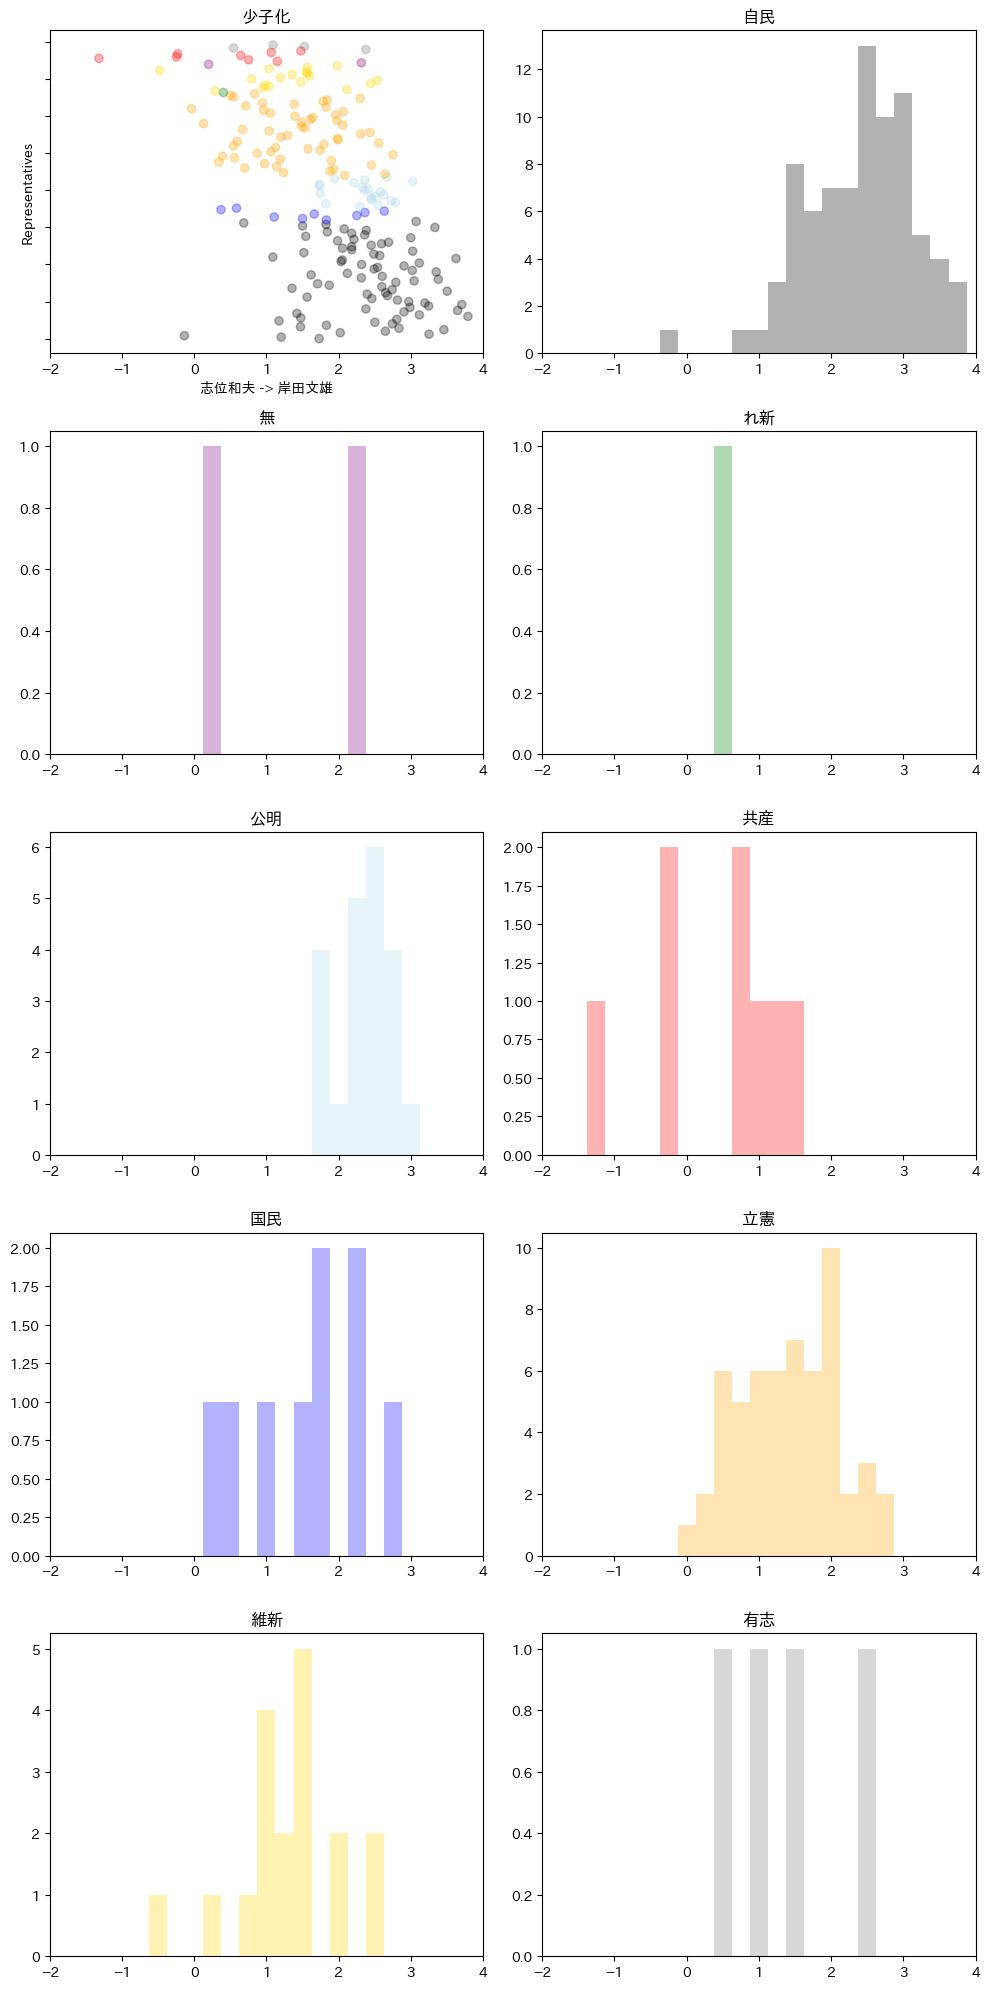

In [6]:
for topic_config in EXPERIMENT_CONFIG:
	# try:
		topic = topic_config['topic_name']
		print(f'Visualizing {topic}')
		for_repr_name = topic_config["repr_references"]["for"]
		against_repr_name = topic_config["repr_references"]["against"]
		gen_for_sentence = topic_config["generated_references"]["for"]
		gen_against_sentence = topic_config["generated_references"]["against"]
		projections, reprs = vo.collapse_vectors_onto_two_ref_reprs(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'),
																	topic=topic,
																	ref_repr1=for_repr_name,
																	ref_repr2=against_repr_name)
		parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]

		psv.save_1d_plot(xs=projections,
					reprs=reprs,
					colors=[PARTY_TO_COLOR[party] for party in parties],
					parties=parties,
					filename=topic+'_1d',
					out_dir=TODAYS_RESULTS)

		psv.visualize(xs=projections,
					labels=reprs,
					colors=[PARTY_TO_COLOR[party] for party in parties],
					parties=parties,
					title=topic,
					xlabel=f'{against_repr_name} -> {for_repr_name}',
					path=os.path.join(TODAYS_PLOTS ,f'{topic}.png')
					)
		box_plot_data = [[projection for idx, projection in enumerate(projections) if parties[idx] == party] for party in PARTIES if party not in IGNORE_PARTIES]
		psv.draw_box_plot(data=box_plot_data, labels=[party for party in PARTIES if party not in IGNORE_PARTIES], title=f"{TOPICJP_TO_TOPICEN[topic]} Representative References", xlabel='Political Stance', ylabel='Parties', path=os.path.join(TODAYS_PLOTS ,f'{topic}_box_plot.png'))
		
		projections, reprs = vo.collapse_vectors_onto_two_genenerated_strings(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'),
																			topic=topic,
																			string1=gen_for_sentence,
																			string2=gen_against_sentence)
		parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]
		
		psv.save_1d_plot(xs=projections,
					reprs=reprs,
					colors=[PARTY_TO_COLOR[party] for party in parties],
					parties=parties,
					filename=topic+'_gen_1d',
					out_dir=TODAYS_RESULTS)

		psv.visualize(xs=projections,
					labels=reprs,
					colors=[PARTY_TO_COLOR[party] for party in parties],
					parties=parties,
					title=topic,
					xlabel=f'against -> for',
					path=os.path.join(TODAYS_PLOTS ,f'{topic}_gen.png')
					)
		
		box_plot_data = [[projection for idx, projection in enumerate(projections) if parties[idx] == party] for party in PARTIES if party not in IGNORE_PARTIES]

		psv.draw_box_plot(data=box_plot_data, labels=[party for party in PARTIES if party not in IGNORE_PARTIES], title=f"{TOPICJP_TO_TOPICEN[topic]} Generated Reference", xlabel='Political Stance', ylabel='Parties', path=os.path.join(TODAYS_PLOTS ,f'{topic}_gen_box_plot.png'))
	# except Exception as e:
	# 	logger.message(f'Error visualizing {topic}')
	# 	logger.message(e)
		

## 6. Reduce dimensionality and visualize everything on 2D plane

In [ ]:
for topic_config in EXPERIMENT_CONFIG:
	# try:
		topic = topic_config['topic_name']
		print(f'Visualizing {topic}')
		for_repr_name = topic_config["repr_references"]["for"]
		against_repr_name = topic_config["repr_references"]["against"]
		gen_for_sentence = topic_config["generated_references"]["for"]
		gen_against_sentence = topic_config["generated_references"]["against"]
		gen_for_embedding = st.encode(gen_for_sentence, convert_to_tensor=True, show_progress_bar=True)
		gen_against_embedding = st.encode(gen_against_sentence, convert_to_tensor=True, show_progress_bar=True)
		gen_for_embedding = gen_for_embedding.cpu().numpy()
		gen_for_embedding = np.mean(gen_for_embedding, axis=0)
		gen_against_embedding = gen_against_embedding.cpu().numpy()
		gen_against_embedding = np.mean(gen_against_embedding, axis=0)
		embeddings, reprs = vo.get_embeddings_and_reprs(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'))
		extended_embeddings = np.concatenate((embeddings, [gen_for_embedding, gen_against_embedding]), axis=0)
		parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]
		extended_reprs = reprs + [gen_for_sentence, gen_against_sentence]
		extended_parties = parties + ['', '']
		all_red_embeddings = vo.reduce_dimensions_umap(extended_embeddings, n_components=2)
		colors = [PARTY_TO_COLOR[party] for party in parties]
		
		#first generating umap with reference representatives
		for_repr_idx = reprs.index(for_repr_name)
		against_repr_idx = reprs.index(against_repr_name)
		psv.visualize_red_dimension(
						all_red_embeddings[:-2], 
						reprs, 
						topic, 
						parties, 
						colors, 
						for_repr_idx=for_repr_idx, 
						against_repr_idx=against_repr_idx, 
						path=os.path.join(TODAYS_PLOTS ,f'{topic}_umap.png'), 
						title=f'Political stance for {TOPICJP_TO_TOPICEN[topic]} with Reference Representatives', 
						show_repr_names=True)
		psv.visualize_red_dimension(
						all_red_embeddings[:-2], 
						reprs, 
						topic, 
						parties, 
						colors, 
						for_repr_idx=for_repr_idx, 
						against_repr_idx=against_repr_idx, 
						path=os.path.join(TODAYS_PLOTS ,f'{topic}_umap_clean.png'), 
						title=f'Political stance for {TOPICJP_TO_TOPICEN[topic]} with Reference representatives', 
						show_repr_names=False)
		psv.save_2d_plot(
						red_dims=all_red_embeddings[:-2],
						reprs=reprs,
						colors=[PARTY_TO_COLOR[party] for party in parties],
						parties=parties,
						filename=topic+'_2d',
						out_dir=TODAYS_RESULTS,
						for_repr_idx=for_repr_idx,
						against_repr_idx=against_repr_idx,
						for_repr_name=for_repr_name,
						against_repr_name=against_repr_name)

		#now generating umap with generated sentences
		extended_colors = colors + ['brown', 'brown']
		gen_for_idx = extended_reprs.index(gen_for_sentence)
		gen_against_idx = extended_reprs.index(gen_against_sentence)
		psv.visualize_red_dimension(
						all_red_embeddings, 
						extended_reprs, 
						topic, 
						extended_parties, 
						extended_colors, 
						for_repr_idx=gen_for_idx, 
						against_repr_idx=gen_against_idx, 
						path=os.path.join(TODAYS_PLOTS,f'{topic}_umap_gen.png'), 
						title=f'Political stance for {TOPICJP_TO_TOPICEN[topic]} with Generated sentences', 
						show_repr_names=False)
	# except Exception as e:
	# 	print(e)
	# 	continue
	

# Topic Modelling on Politicians 

In [8]:
#https://qiita.com/hima2b4/items/e2fe3942b8e7253b8ed6
import json
import numpy as np
import re
import MeCab
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import pandas as pd

def create_groups(reprs, projections, parties, num_groups=3):
    axis_range = np.max(projections) - np.min(projections)
    portion_size = axis_range / num_groups
    dividing_points = [np.min(projections) + i * portion_size for i in range(1, num_groups)]

    groups = np.digitize(projections, dividing_points)

    group_dict = [{'group_num':group_num, 'politicians': [], 'parties': []} for group_num in range(num_groups)]

    for rep, group, party in zip(reprs, groups, parties):
        group_dict[group]['politicians'].append(rep)
        group_dict[group]['parties'].append(party)

    return group_dict

class TopicModeller:
    def __init__(self,  topic=''):
        self.embedding_handler = EmbeddingHandler()
        self.topic = topic
        self.reprs = self.embedding_handler.reprs
        self.tagger = MeCab.Tagger()
        self.stop_words = [word.strip() for word in list(set(read_txt_file('./stopwords-ja.txt')))]
        self.exp_config = next((item for item in EXPERIMENT_CONFIG if item["topic_name"] == topic), None)
        self.search_words = self.exp_config["search_words"]
        MODEL_NAME = "cl-tohoku/bert-base-japanese-v3"
        self.topic_model = BERTopic(language="japanese", calculate_probabilities=True, embedding_model=MODEL_NAME)

    # def create_groups(self, reprs, projections, parties, num_groups=3):
    #     axis_range = np.max(projections) - np.min(projections)
    #     portion_size = axis_range / num_groups
    #     dividing_points = [np.min(projections) + i * portion_size for i in range(1, num_groups)]

    #     groups = np.digitize(projections, dividing_points)

    #     group_dict = [{'group_num':group_num, 'politicians': [], 'parties': []} for group_num in range(num_groups)]

    #     for rep, group, party in zip(reprs, groups, parties):
    #         group_dict[group]['politicians'].append(rep)
    #         group_dict[group]['parties'].append(party)

    #     return group_dict

    def preprocess_opinion(self, text, ignore_search_words=False, ignore_stop_words=False):
         # 改行コード、タブ、スペース削除
        text = ''.join(text.split())
        # URLの削除
        text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text)
        # メンション除去 
        text = re.sub(r'@([A-Za-z0-9_]+)', '', text) 
        # 記号の削除
        text = re.sub(r'[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥]', '', text)

        text = re.sub('[、\r\n\u3000]', '', text)
        # stop_wordsを'|'で連結して正規表現パターンを作る
        pattern = ''
        if ignore_stop_words:
            pattern = '|'.join(self.stop_words)
            text = re.sub(pattern, '', text)
        if ignore_search_words:
            pattern = '|'.join(self.search_words)
            text = re.sub(pattern, '', text)

        return text
        
    # DO NOT USE THIS FUNCTION
    # def extract_opinions_by_topic(self, group_dict):
    #     group_dict_copy = group_dict.copy()

    #     for group_num, group_info in group_dict.items():
    #         opinion_sentences = []
    #         # print('working on group number', group_num)
    #         for politician in tqdm(group_info['politicians']):
    #             # print('working on politician', politician)
    #             try:
    #                 _, _, opinions = self.embedding_handler.get_embeddings_for_repr_for_topic(politician, self.topic)

    #                 opinion_sentences.extend(opinions)
    #             except ValueError:
    #                 print(f'No opinions for {politician} for {self.topic}')
    #                 continue
                    
    #         preprocessed_opinions = self.preprocess_opinions(opinion_sentences)
    #         group_dict_copy[group_num]['opinions_text'] = preprocessed_opinions

    #     return group_dict_copy
    
    def get_sentences_for_politicians_for_topic(self, politicians, topic):
        opinion_sentences = []
        for politician in politicians:
            try:
                _, _, opinions = self.embedding_handler.get_embeddings_for_repr_for_topic(politician, topic)
                opinion_sentences.extend(opinions)
            except ValueError:
                print(f'No opinions for {politician} for {topic}')
                continue
        return opinion_sentences
    
    # def get_topic_search_words(self) -> list:
    #     """ 
    #     get the list of search words based on the topic 
    #     """
        
    #     with open('../data_prepping/resource/experiment_config.json', encoding='utf-8') as f:
    #         file_with_search_words = json.loads(f.read())
        
    #     for dic in file_with_search_words:    
    #         if self.topic in dic["topic_name"]:
    #             return dic["search_words"]
            
    def tokens_to_exclude(self, text, keep=["PROPN", "NOUN"]) -> list:
        """
        get all the words we want to exclude. that is, if they:
            - aren't a certain part of speech: either proper noun (=PROPN) or noun (=NOUN) OR 
            - are a meaningless stopword (i.e., もの、こと、さん) OR
            - are a key topic search word 
        """
        
        # get tokens that are not proper nouns or nouns 
        nlp = spacy.load("ja_core_news_sm")
        doc = nlp(text)

        tokens_to_remove = [token.text for token in doc if token.pos_ not in keep] + self.stop_words + self.search_words
        return tokens_to_remove


    def bert_tokenizer(self, text):
        try:
            text = re.sub('[、\r\n\u3000]', '', text)
            words = self.tagger.parse(text).split()
            return words
        except Exception as e:
            print(e)
            logger.info(f'Preprocessed text: {text}')
            logger.info(f'Words: {words}')
            raise e


    def apply_bertopic_to_sentences(self, sentences, nr_topics=10):

        # words_removed_list = [self.bert_tokenizer(self.tokens_to_exclude(text)) for text in group_dict[group_num]['opinions_text']]
        words_removed_list = [self.bert_tokenizer("".join(self.tokens_to_exclude(text))) for text in sentences]
        words_removed_set_list = list(set(sum(words_removed_list, [])))
        # logger.info(f'Words removed: {words_removed_set_list}')

        vectorizer_model = CountVectorizer(tokenizer=self.bert_tokenizer, stop_words=words_removed_set_list)

        model = BERTopic(
            verbose=True,
            embedding_model=MODEL_NAME,
            nr_topics=nr_topics,
            vectorizer_model=vectorizer_model
        )
        
        model.fit_transform(sentences)

        return model
    
    def lda_tokenizer(self, text, keep=["PROPN", "NOUN"]) -> list:
        """
        get all the words we want to include. that is, if they:
            - are a certain part of speech: either proper noun (=PROPN) or noun (=NOUN) OR 
            - aren't a meaningless stopword (i.e., もの、こと、さん) OR
            - aren't a key topic search word 

        different from BERTopic's because of when we can access the texts and apply the filter 
        """
        
        # get tokens that are not proper nouns or nouns 
        nlp = spacy.load("ja_core_news_sm")
        doc = nlp(text)

        included_tokens = [token.text for token in doc if token.pos_ in keep and token.text not in self.stop_words]

        return included_tokens

    def apply_lda(self, group_dicts, num_topics=3):
        print('applying lda')
        lda_model = make_pipeline(CountVectorizer(analyzer=self.lda_tokenizer,),
                                  LatentDirichletAllocation(n_components=num_topics, random_state=42, verbose=True))

        group_topics = {}

        for group_info in group_dicts:
            opinion_sentences = []

            for politician in tqdm(group_info['politicians']):
                try:
                    _, _, opinions = self.embedding_handler.get_embeddings_for_repr_for_topic(politician, self.topic)
                    opinion_sentences.extend(opinions)
                except ValueError:
                    continue
            print('fitting lda model')
            
            lda_model.fit(opinion_sentences)
        
            # get topics and their associated words
            feature_names = lda_model.named_steps['countvectorizer'].get_feature_names_out()
            topics = []

            # create dict for three groups 
            print('creating dict for the topics')
            for topic_idx, tp in enumerate(lda_model.named_steps['latentdirichletallocation'].components_):
                topic_words = [feature_names[i] for i in tp.argsort()[:-10 - 1:-1]]

                topics.append(topic_words)

            group_topics[group_info['group_num']] = topics

        return group_topics

In [10]:
for topic_config in EXPERIMENT_CONFIG:
	logger.info(f'Topic modelling for {topic_config["topic_name"]}')
	topic = topic_config['topic_name']
	if topic not in ['原発', '防衛']:
		continue
	output_path = os.path.join(TODAYS_RESULTS, f'{topic}_lda.json')
	if os.path.exists(output_path):
		print(f'{output_path} already exists')
		continue
	print(f'Topic modelling for {topic}')
	for_repr_name = topic_config["repr_references"]["for"]
	against_repr_name = topic_config["repr_references"]["against"]
	gen_for_sentence = topic_config["generated_references"]["for"]
	gen_against_sentence = topic_config["generated_references"]["against"]
	projections, reprs = vo.collapse_vectors_onto_two_ref_reprs(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'),
																topic=topic,
																ref_repr1=for_repr_name,
																ref_repr2=against_repr_name)
	parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]
	group_dicts = create_groups(reprs, projections, parties = parties)
	print('Grouped politicians by political stance')
	print('Number of groups', len(group_dicts))
	#######################TEST###############################
	# group_dict = group_dicts[1]
	# topic_modeller = TopicModeller(topic=topic)
	# politicians = group_dict['politicians']
	# parties = group_dict['parties']
	# opinion_sentences = topic_modeller.get_sentences_for_politicians_for_topic(politicians, topic)
	# opinion_sentences = rnd.choices(opinion_sentences, k=min(len(opinion_sentences),1000))
	# logger.info(f'Number of opinion sentences for {topic} for group {group_dict["group_num"]}: {len(opinion_sentences)}')
	# model = topic_modeller.apply_bertopic_to_sentences(opinion_sentences)
	# freq = model.get_topic_info()
	# freq.to_csv(os.path.join(TODAYS_RESULTS, f'{topic}_bertopic_group_{group_dict["group_num"]}.csv'), index=False)
	# break
	###################################################################
	for group_dict in group_dicts:
		topic_modeller = TopicModeller(topic=topic)
		politicians = group_dict['politicians']
		parties = group_dict['parties']
		opinion_sentences = topic_modeller.get_sentences_for_politicians_for_topic(politicians, topic)
		# opinion_sentences = [topic_modeller.preprocess_opinion(opinion, ignore_search_words=True, ignore_stop_words=True) for opinion in opinion_sentences]
		opinion_sentences = rnd.choices(opinion_sentences, k=min(len(opinion_sentences),1000))
		model = topic_modeller.apply_bertopic_to_sentences(opinion_sentences)
		freq = model.get_topic_info()
		freq.to_csv(os.path.join(TODAYS_RESULTS, f'{topic}_bertopic_group_{group_dict["group_num"]}.csv'), index=False)
	lda_model = topic_modeller.apply_lda(group_dicts, 3)
	write_json(path=os.path.join(TODAYS_RESULTS, f'{topic}_lda.json'), dict_obj=lda_model)

Topic modelling for 防衛
Grouped politicians by political stance
Number of groups 3


2024-02-06 22:09:21,647 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s]
2024-02-06 22:09:26,151 - BERTopic - Embedding - Completed ✓
2024-02-06 22:09:26,152 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
/root/projects/kokkai_analysis/data_prepping/kokkai_venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
2024-02-06 22:09:33,831 - BERTopic - Dimensionality - Completed ✓
2024-02-06 22:09:33,834 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-06 22:09:33,860 - BERTopic - Cluster - Completed ✓
2024-02-06 22:09:33,861 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-06 22:09:34,458 - BERT

In [ ]:
n = 3 # how many times we split the graph
topic_str = '防衛'

embedding_handler = EmbeddingHandler()
topic_modeller = TopicModeller(n, 
							   projections, 
							   embedding_handler=embedding_handler, 
							   topic=topic_str)

group_dict = topic_modeller.create_groups()
group_dict = topic_modeller.extract_opinions_by_topic(group_dict)

## LDA

In [ ]:
lda_model = topic_modeller.apply_lda(group_dict, 3)

lda_model 

## ran for 19min 

## output for '
# {1: [['自衛', '隊', '安全', '御', '保障', '力', '省', '方', '問題', 'ども'],
#   ['安全', '保障', '国', '省', '国民', '御', '環境', '国際', '隊', '自衛'],
#   ['省', '財源', '御', '国債', '費', 'ミサイル', '核', '委員', '安全', '建設']],
#  2: [['安全', '保障', '国', '国際', '経済', '社会', '性', 'エネルギー', '観点', '平和'],                                                                                                                                                                      
#   ['安全', '保障', '国', '自衛', '国家', '隊', '憲法', '中', '力', '権'],
#   ['自衛', '隊', '大臣', '安全', '保障', '国', '中', '事態', '方', '御']],
#  3: [['自衛', '隊', '権', '集団', '国', '法', '省', '憲法', '大臣', '方'],
#   ['安全', '保障', '国', '環境', '中', '認識', '日米', '国際', '経済', '平和'],
#   ['力', '強化', '財源', '御', '国民', '大臣', '予算', '抜本', '費', '確保']]}

### BERTopic

In [ ]:
group_1 = topic_modeller.apply_bertopic(group_dict, 1, 10) # left of the graph (ideologically right)
# group_2 = topic_modeller.apply_bertopic(group_dict, 2, 10) # centre of the graph
# group_3 = topic_modeller.apply_bertopic(group_dict, 3, 10) # right of the graph (ideologically left)
group_1.get_topic_info()

## other useful methods in BERTopic
# group_1.visualize_barchart(n_words=10)
# group_1.visualize_topics()
## if you want to check how many opinions are in each group 
# len(group_dict[1]['opinions_text'])
# len(group_dict[2]['opinions_text'])
# len(group_dict[3]['opinions_text'])